In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
data_dir = '/content/drive/MyDrive/DATASET'
classes = ['tank,soldiers', 'base,plane']

In [6]:
# Load and preprocess image data
def load_and_preprocess_data(data_dir, classes, target_shape=(128, 128)):
    data = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg'):
                file_path = os.path.join(class_dir, filename)
                # Load and preprocess the image
                img = load_img(file_path, target_size=target_shape)
                img_array = img_to_array(img)
                data.append(img_array)
                labels.append(i)

    return np.array(data), np.array(labels)

# Split data into training and testing sets
data, labels = load_and_preprocess_data(data_dir, classes)
labels = to_categorical(labels, num_classes=len(classes))  # Convert labels to one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = X_train[0].shape

# Load the VGG19 model without the top layer and with pre-trained ImageNet weights
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the VGG19 base layers to retain pre-trained features
vgg16_base.trainable = False

# Add custom layers on top
x = Flatten()(vgg16_base.output)
x = Dense(64, activation='relu')(x)  # Fully connected layer
output_layer = Dense(len(classes), activation='softmax')(x)  # Output layer for classification

# Create the complete model
model = Model(inputs=vgg16_base.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
# Train the model and store the training history
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the test set
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy[1]}')

# Save the model
model.save('image_classification_model.h5')


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 474s 8s/step - accuracy: 0.6627 - loss: 2.6533 - val_accuracy: 0.6946 - val_loss: 0.5475
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 502s 8s/step - accuracy: 0.8440 - loss: 0.3626 - val_accuracy: 0.7425 - val_loss: 0.6105
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 541s 8s/step - accuracy: 0.9246 - loss: 0.1885 - val_accuracy: 0.7385 - val_loss: 0.6837
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 564s 8s/step - accuracy: 0.9687 - loss: 0.1019 - val_accuracy: 0.7285 - val_loss: 0.8192
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 511s 7s/step - accuracy: 0.9713 - loss: 0.0843 - val_accuracy: 0.7645 - val_loss: 0.8807
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 462s 7s/step - accuracy: 0.9810 - loss: 0.0635 - val_accuracy: 0.7784 - val_loss: 0.8421
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 461s 7s/step - accuracy: 0.9881 - loss: 0.0407 - val_accuracy: 0.7545 - val_loss: 0.8829
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 461s 7s/step - accuracy: 0.9860 - loss: 0.0478 - val_accuracy: 0.7585 - v

Test accuracy: 0.7604790329933167


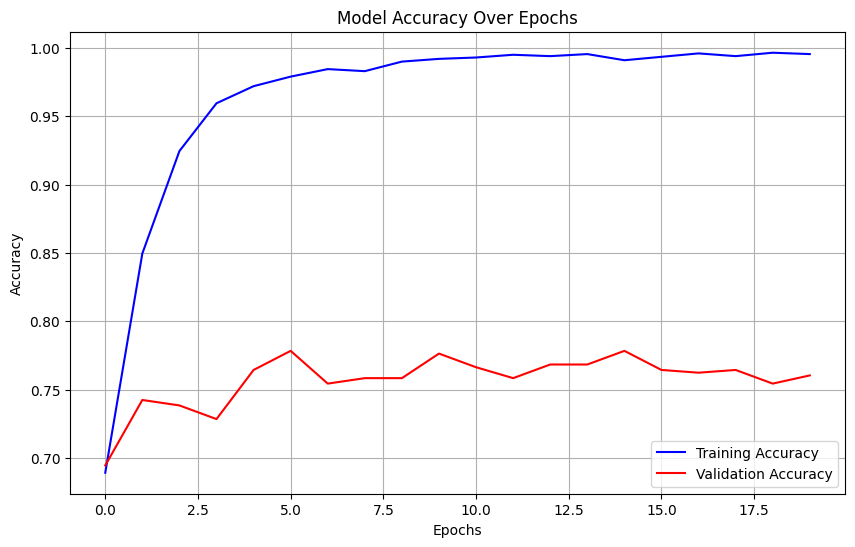

In [10]:
import matplotlib.pyplot as plt

# Plot the accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import glob

# Load your pre-trained VGG16 model
model = load_model('image_classification_model.h5')

# Define the target shape as the shape used during training (128, 128)
target_shape = (128, 128)  # Ensure this matches your model's input size

# Define your class labels
classes = ['base,plane', 'tank,soldiers']

# Preprocessing function for VGG16
def preprocess_for_vgg16(img_array):
    return preprocess_input(img_array)

# Function to classify a single image
def test_image(file_path, model):
    try:
        # Load and preprocess the image
        img = load_img(file_path, target_size=target_shape)  # Ensure target size matches training input size
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_for_vgg16(img_array)  # Preprocessing step for VGG16

        # Predict the class probabilities
        predictions = model.predict(img_array)

        # Get class probabilities for the first image in the batch (if batch processing)
        class_probabilities = predictions[0]

        # Get the index of the predicted class
        predicted_class_index = np.argmax(class_probabilities)

        # Get the name of the predicted class
        predicted_class = classes[predicted_class_index]

        return predicted_class, class_probabilities
    except Exception as e:
        print(f"Error processing image {file_path}: {e}")
        return None, None

# Function to classify all images in a folder
def classify_images_in_folder(folder_path, model):
    # Generate a list of image files in the folder (handle .jpg and other formats)
    image_files = glob.glob(os.path.join(folder_path, '*.jpg'))

    if not image_files:
        print("No images found in the specified directory.")
        return

    # Loop over all images in the folder
    for filename in image_files:
        print(f"\nProcessing image: {os.path.basename(filename)}")
        predicted_class, class_probabilities = test_image(filename, model)

        if predicted_class:
            print(f"Predicted Class: {predicted_class}")
            for i, class_label in enumerate(classes):
                probability = class_probabilities[i]
                print(f'  Class: {class_label}, Probability: {probability:.4f}')
        else:
            print(f"Skipped processing image: {filename} due to an error")

# Define folder path with test images (modify this path with the location of your images)
test_images_folder = '/content/drive/MyDrive/DATASET/test'  # Modify as necessary

# Call the function to classify all images in the folder
print("\nClassifying images in the folder:")
classify_images_in_folder(test_images_folder, model)



Classifying images in the folder:

Processing image: img553_jpg.rf.a81868ed6c6253037b2a0f41f7d14e69.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicted Class: base,plane
  Class: base,plane, Probability: 0.9532
  Class: tank,soldiers, Probability: 0.0468

Processing image: img1920_jpg.rf.82588fa23b4418017835d085989683b6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Predicted Class: base,plane
  Class: base,plane, Probability: 0.9789
  Class: tank,soldiers, Probability: 0.0211

Processing image: mg144_jpg.rf.25d2f10522edf2aec453623d51c0f6d3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Predicted Class: base,plane
  Class: base,plane, Probability: 0.9414
  Class: tank,soldiers, Probability: 0.0586

Processing image: img0_jpg.rf.7d902340a5db3d37a362a2cbdd38a536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
Predicted Class: tank,soldiers
  Class: base,plane, Probability: 0.0104
  Class: tank,soldiers, Probability: 0.9896

Processing image: img847_jpg.rf.b1d286a18f315d07226b8ed470c67fbf.jpg
1/1 ━━